In [11]:
%matplotlib inline

# Training Q-Learning to play Black Jack with Basic Strategy

-  *Object of the Player:* Each player tries to obtain a total that is greater than that of the dealer
but that does not exceed 21

Current version os non-Natural Black Jack, where the dealer does not check for Black Jack when showing an Ace or a 10-value card.

### 1.Task
- Environment Setup: Create an environment for the Blackjack game. This environment should be able to take actions as input (like hit, stand, etc.) and return the new state and reward.

In [12]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

In [13]:
class BlackjackEnvironment:
    def __init__(self):
        self.deck = self.generate_deck()
        self.player_hand = []
        self.dealer_hand = []
        self.split_hand = []
        self.doubled_down = False
        
        self.reward_queue = []  
        self.length_queue = []  
        
        self.reset()

    
    def generate_deck(self):
        suits = ['hearts', 'diamonds', 'clubs', 'spades']
        values = list(range(2, 11)) + ['jack', 'queen', 'king', 'ace']
        deck =[str(value) + '_' + suit for value in values for suit in suits]
        random.shuffle(deck)
        return deck

    
    def draw_card(self):
        if not self.deck:
            self.deck = self.generate_deck()
        return self.deck.pop()

    def reset(self):
        self.player_hand = [self.draw_card(), self.draw_card()]
        self.dealer_hand = [self.draw_card(), self.draw_card()]

    def card_value(self, card):
        value = card.split('_')[0]
        if value in ['jack', 'queen', 'king']:
            return 10
        elif value == 'ace':
            return 11
        else:
            return int(value)

    def hand_value(self, hand):
        value = sum(self.card_value(card) for card in hand)
        if value > 21 and any(card.startswith('ace') for card in hand):
            value -= 10
        return value
    
    def is_soft(self, hand):
        return any(card.startswith('ace') for card in hand) and self.hand_value(hand) <= 21 

    def is_busted(self, hand):
        return self.hand_value(hand) > 21

    def dealer_play(self):
        while self.hand_value(self.dealer_hand) < 17:
            self.dealer_hand.append(self.draw_card())
            
    
    def is_pair(self, hand):
        if len(hand) == 2:
            return hand[0].split('_')[0] == hand[1].split('_')[0]
        
                  
    def step(self, action):
        
        complete_card_count = self.complete_count_cards(self.player_hand, self.dealer_hand)
        # Perform the given action ('h' for hit, 's' for stand) and return the next state, reward, and if the game has ended.
        if action == 'h':
            # Player chooses to hit and draws a card.
            
            self.player_hand.append(self.draw_card())
            if self.is_busted(self.player_hand):
                reward = -1
                self.length_queue.append(len(self.player_hand))  # Update length_queue
                if self.doubled_down:
                    self.reward_queue.append(-2)  # Update return_queue
                    return 'terminal', -2, True
                else:
                # Player is busted and loses the game.
                # give extra penalty more if card counting is low 
                    if complete_card_count < -30:
                        reward -= 0.5 
                    if complete_card_count < -50:
                        reward -= 1.0  
                    if complete_card_count < -60:
                        reward -= 1.5
                    self.reward_queue.append(reward)  # Update return_queue
                    return 'terminal', reward, True
            else:
                return self.get_state(), 0, False
                    
        elif action == 's':
            # Player chooses to stand and the dealer plays their turn.
            self.dealer_play()
            player_value = self.hand_value(self.player_hand)
            dealer_value = self.hand_value(self.dealer_hand)
            
            complete_card_count = self.complete_count_cards(self.player_hand, self.dealer_hand)

            if self.is_busted(self.dealer_hand) or player_value > dealer_value:
                # Player wins if the dealer is busted or has a lower hand value.
                reward = 1
                if complete_card_count > 25:  # If the card count is high, give extra reward
                    reward += 0.5
                elif complete_card_count > 30: 
                    reward += 1.0
                elif complete_card_count > 50:
                    reward += 1.5
                # Player wins if the dealer is busted or has a lower hand value.
                self.reward_queue.append(reward)  # Update return_queue
                self.length_queue.append(len(self.player_hand))  # Update length_queue
                return 'terminal', reward, True
            elif dealer_value > player_value:
                reward = -1
                # Player loses if the dealer has a higher hand value.
                self.length_queue.append(len(self.player_hand))  # Update length_queue
                # give extra penalty more if card counting is low 
                if complete_card_count < -30:
                    reward -= 0.5 
                if complete_card_count < -40:
                    reward -= 1.0  
                if complete_card_count < -50:
                    reward -= 1.5
                self.reward_queue.append(reward)  # Update return_queue
                return 'terminal', -1, True
            else:
                # The game is a tie if the player and dealer have the same hand value.
                self.reward_queue.append(0)  # Update return_queue
                self.length_queue.append(len(self.player_hand))  # Update length_queue
                return 'terminal', 0, True
        # If the game is not over, return the current state, reward of 0, and False for not done.
        return self.get_state(), 0, False
    
    
    def count_cards(self, hand):
        # The simplest form of card counting - the Hi-Lo system
        count = 0
        #Each time you see one of the cards used in play, subtract 1 from the current total. 
        for card in hand:
            card_value = self.card_value(card) 
            if card_value in [2, 3, 4, 5, 6]:
                count += 1
            elif card_value == 10 or card.startswith('ace'):
                count -= 1
        return count 
    
    # Counting card with complete point count        
    def complete_count_cards(self,hand, dealer_hand):
        total_count = self.count_cards(hand)
        unseen_cards = len(self.deck) - len(hand) - len(dealer_hand) 
        if unseen_cards == 0:  # Avoid division by zero
            return 0
        high_low_index = total_count / unseen_cards
        return high_low_index*100
    
        
    def get_state(self):
        # Return the current state as a tuple containing the player's hand value and the dealer's up card value.
        return (self.hand_value(self.player_hand), self.card_value(self.dealer_hand[0]), self.is_soft(self.player_hand),self.complete_count_cards(self.player_hand, self.dealer_hand))


class QLearningAgent:
    def __init__(self, env, num_episodes, initial_epsilon, epsilon_decay, final_epsilon, alpha=0.1, gamma=0.99):
        # Initialize the Q-learning agent with the given environment and learning parameters.
        self.env = env
        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor
        self.epsilon = initial_epsilon  # Exploration rate
        self.num_episodes = num_episodes  # Number of episodes to train
        self.epsilon_decay = epsilon_decay # Decay rate for epsilon
        self.final_epsilon = final_epsilon
        self.Q = {}  # Q-value dictionary mapping (state, action) pairs to Q-values
        self.training_error = []
        self.epsilon_list = []

    def get_Q(self, state, action):
        return self.Q.get((state, action), 0)
    
    

    def choose_action(self, state):
        '''
        Choose an action to take in the given state based on the current Q-values and exploration rate.
        '''
        player_hand = state[0]
        dealer_hand = state[1]
        complete_card_count = state[3]
        #print(complete_card_count)
       
        # Choose an action based on the current Q-values and exploration rate.
        if np.random.random() < self.epsilon:
            self.epsilon_list.append(self.epsilon)
            # Choose a random action with probability epsilon (exploration).
            return random.choice(['h', 's'])
        else:
            return max(['h', 's'], key=lambda action: self.Q.get((state, action), 0))
            '''
            if complete_card_count >= 2:  # If the count is high, favor 'stand'
                if np.random.random() < 0.5:  # Still allow some randomness to ensure exploration
                    return 'h'
                else:
                    return 's'
            elif complete_card_count <= -2:  # If the count is low, favor 'hit'
                if np.random.random() < 0.5:  # Still allow some randomness to ensure exploration
                    return 's'  
                else:
                    return 'h'
            else:  # If the count is neutral, rely on the Q-values
                # Choose the action with the highest Q-value (exploitation). Act GREEDY
                return max(['h', 's'], key=lambda action: self.Q.get((state, action), 0))
            '''
                

    def update(self, state, action, next_state, reward):
        # Update the Q-value table using the Q-learning update rule.

        # Get the current Q-value for the given state and action.
        current_q = self.Q.get((state, action), 0)
        
        # Get the maximum Q-value for the next state across all actions.
        next_q = max(self.Q.get((next_state, a), 0) for a in ['h', 's'])
        
        # Training error
        temporal_difference = reward + self.gamma * next_q - current_q
        
        # Update the Q-value for the current state and action using the Q-learning update rule. 
        self.Q[(state, action)] = current_q + self.alpha * temporal_difference
        
        # Append the temporal difference to the training error list.
        self.training_error.append(temporal_difference)
    
    # Decay epsilon
    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)
    
    def train(self, num_episodes):
    # Train the Q-learning agent by running the algorithm for the specified number of episodes.
        for episode in range(num_episodes):
            # Loop through each episode in the total number of episodes to train.
            self.env.generate_deck()
            self.env.reset()
            state = self.env.get_state()
            # Get the initial state from the environment.
            done = False
            # Set the "done" flag to False, indicating that the episode is not yet finished.
            while not done:
                # Choose an action based on the current state using the Q-learning agent's policy.
                action = self.choose_action(state)
                # Take the chosen action in the environment and receive the next state, reward, and a flag indicating if the episode is done.
                next_state, reward, done = self.env.step(action)
                # Update the Q-value table using the current state, action, next state, and reward.
                self.update(state, action, next_state, reward)
                # Update the current state to be the next state for the next iteration of the loop.
                state = next_state  
            # Decay epsilon
            self.decay_epsilon()

### Task 2
- *Agent Implementation:* Implement a reinforcement learning agent. This agent should have a policy that it follows, and it should be able to update this policy based on the rewards it gets.

Agent Action: 1 = Hit, 0 = Stand, 2= Split, 3 = Double Down 

To ensure that the agents explores the environment, one possible solution is the epsilon-greedy strategy. This strategy takes a random action with probability epsilon, and the best action based on the policy with probability 1-epsilon. 



### Task 3
- Training: Train the agent by playing many games of Blackjack and updating the policy after each game. Plot the average reward received per game over time (say, every 1000 games), and report your findings. Does your agent learn an optimal policy?

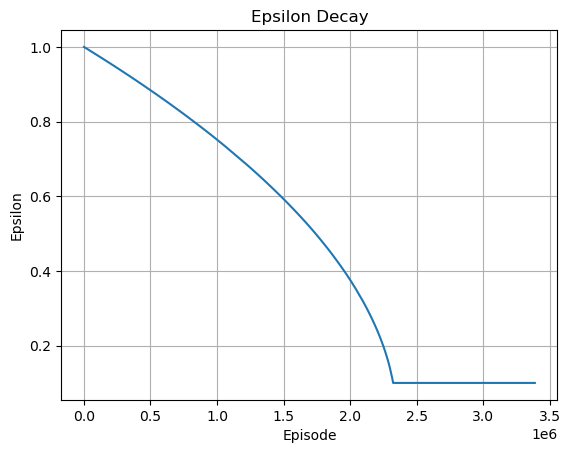

In [14]:
if __name__ == "__main__":
    
    # Hyperparameters
    num_episodes = 10000000
    initial_epsilon = 1.0
    epsilon_decay = initial_epsilon / (num_episodes / 3)  # reduce the exploration over time
    final_epsilon = 0.1
    
    env = BlackjackEnvironment()
    agent = QLearningAgent(env, num_episodes, initial_epsilon, epsilon_decay, final_epsilon)
    
    # Train the agent
    agent.train(num_episodes)

    #visualize the epsilon decay
    epsilon_list = agent.epsilon_list
    plt.plot(epsilon_list)
    plt.xlabel('Episode')
    plt.ylabel('Epsilon')
    plt.title('Epsilon Decay')
    plt.grid()
    plt.show()
    
    

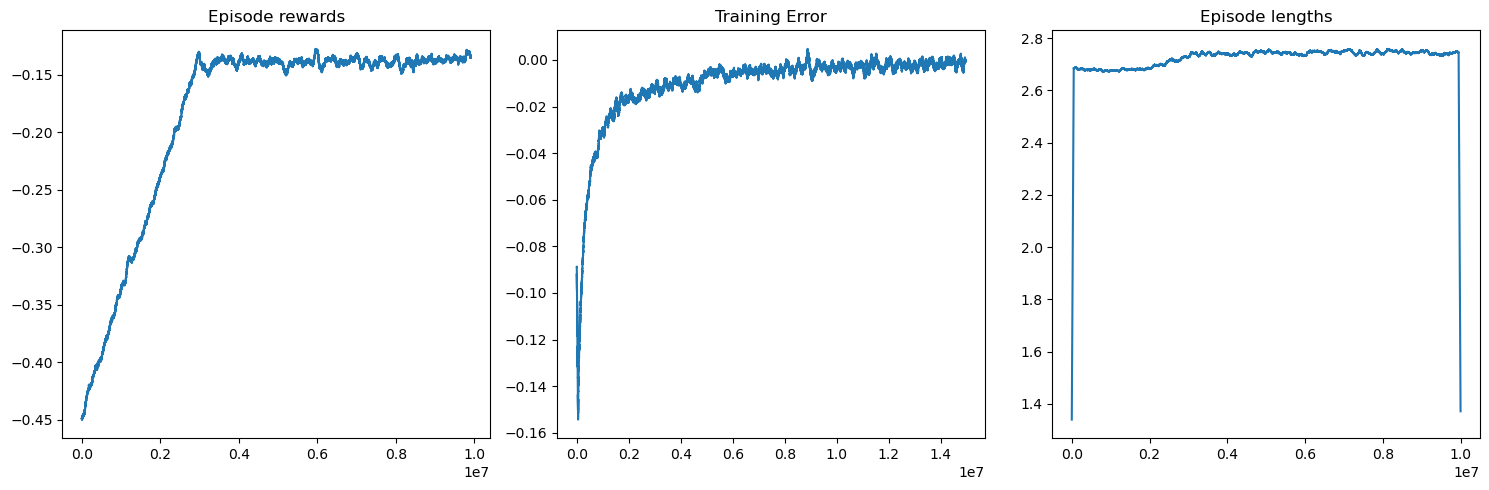

In [15]:

# Visualize the agent training 
length_step = 100000
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))
axs[0].set_title('Episode rewards')

# compute and assign a rolling average of the data to provide a smoother graph
reward_moving_average = (np.convolve(np.array(env.reward_queue).flatten(), np.ones(length_step), mode="valid")/ length_step)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)

axs[1].set_title("Training Error")
training_error_moving_average = (np.convolve(np.array(agent.training_error), np.ones(length_step), mode="same") / length_step)
axs[1].plot(range(len(training_error_moving_average)), training_error_moving_average)

axs[2].set_title("Episode lengths")
length_moving_average = (np.convolve(np.array(env.length_queue).flatten(), np.ones(length_step), mode="same")/ length_step)
axs[2].plot(range(len(length_moving_average)), length_moving_average)

plt.tight_layout()
plt.show()  
    

### Task 4
- Evaluation: Evaluate the agent by having it play many games without updating the policy and see how often it wins. Compare this to a random agent that simply takes random actions at each step. Does your agent perform better than this random agent?

In [23]:
def evaluate_agent(agent, num_games=1000000):
    wins = 0
    losses = 0
    ties = 0

    for _ in range(num_games):
        agent.env.reset()
        state = agent.env.get_state()
        done = False

        while not done:
            action = max(['h', 's'], key=lambda action: agent.Q.get((state, action), 0))
            state, reward, done = agent.env.step(action)

        if reward > 0:
            wins += 1
        elif reward < 0:
            losses += 1
        else:
            ties += 1

    win_rate = wins / num_games
    loss_rate = losses / num_games
    tie_rate = ties / num_games

    return win_rate, loss_rate, tie_rate

win_rate, loss_rate, tie_rate = evaluate_agent(agent)
print(f"Win rate: {win_rate:.3f}, Loss rate: {loss_rate:.3}, Tie rate: {tie_rate:.3f}")


Win rate: 0.424, Loss rate: 0.491, Tie rate: 0.086


### Visualizing the policy
- Visualize the policy that the agent has learned by plotting the value of the state (i.e. the probability of winning) for each possible state of the game. You should plot the value of the state for each possible player hand value (12-21) and each possible dealer hand value (1-10). You should see that the agent has learned to stand when it has a high probability of winning and hit when it has a low probability of winning.

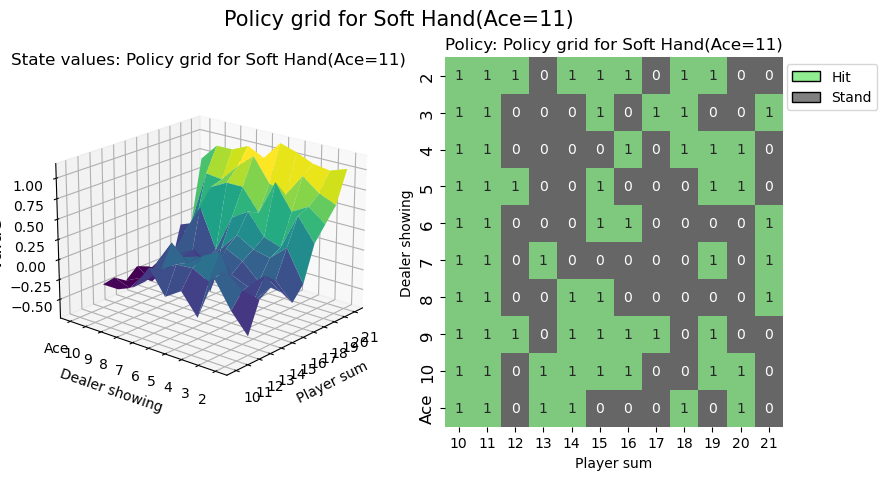

In [24]:
from collections import defaultdict


def create_grids(agent, soft=True):
   """Create value and policy grid given an agent."""
    # convert our state-action values to state values
    # and build a policy dictionary that maps observations to actions
    
   # initialize empty dictionaries for state values and policy 
   state_values = defaultdict(float)
   policy = defaultdict(int)
   
   for state_action in agent.Q.keys():
       state, action = state_action
       #print(state_action)
       #print(state)
       #print(action)
       if state not in policy:
           
           state_values[state] = max(agent.Q.get((state, a), 0) for a in ['h', 's'])
           #print(state_values)

           
           # map 'h' to 1 and 's' to 0
           policy[state] = 1 if action == 'h' else 0
           #policy[state] = action
           #print(action)
           #print(policy)
    
   player_count, dealer_count = np.meshgrid(
        # players count, dealers face-up card
        np.arange(10, 22),
        np.arange(2, 12),
    )
    
   # get the state values for each player and dealer count
   value = np.apply_along_axis(
        lambda state: state_values.get((state[0], state[1], soft,0)),
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
   
   
   value_grid = player_count, dealer_count, value
   
   policy_grid = np.apply_along_axis(
        lambda state: policy.get((state[0], state[1],soft,0), 1),
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
   #print(policy_grid)
   return value_grid, policy_grid
    
# plot the value grid
def plot_grids(value_grid, policy_grid, title: str):
    # crate a plot using balue grid and policy grid
    player_count, dealer_count, value = value_grid
    fig = plt.figure(figsize=plt.figaspect(0.5))
    fig.suptitle(title, fontsize=15)

    
    # plot the state values
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.plot_surface(player_count, dealer_count, value, cmap='viridis')
    plt.xticks(range(10, 22), range(10,22))
    plt.yticks(range(2, 12), [2,3,4,5,6,7,8,9,10,"Ace"])
    ax.set_title(f"State values: {title}")
    ax.set_xlabel("Player sum")
    ax.set_ylabel("Dealer showing")
    ax.zaxis.set_rotate_label(False)
    ax.set_zlabel("Value", fontsize=14, rotation=90)
    ax.view_init(20, 220)
    
    # plot the policy
    fig.add_subplot(1, 2, 2)
    ax2 = sns.heatmap(policy_grid, linewidth=0, annot=True, cmap="Accent_r", cbar=False)
    ax2.set_title(f"Policy: {title}")
    ax2.set_xlabel("Player sum")
    ax2.set_ylabel("Dealer showing")
    ax2.set_xticklabels(range(10, 22))
    
    # 11 is string value for ace, we add it manually
    ax2.set_yticklabels([2,3,4,5,6,7,8,9,10,"Ace"], fontsize=12)
   
    
    # add a legend
    legend_elements = [
        Patch(facecolor="lightgreen", edgecolor="black", label="Hit"),
        Patch(facecolor="grey", edgecolor="black", label="Stand"),
    ]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))
    return fig

# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(agent, soft=True)
fig = plot_grids(value_grid, policy_grid, title="Policy grid for Soft Hand(Ace=11)")
plt.show()

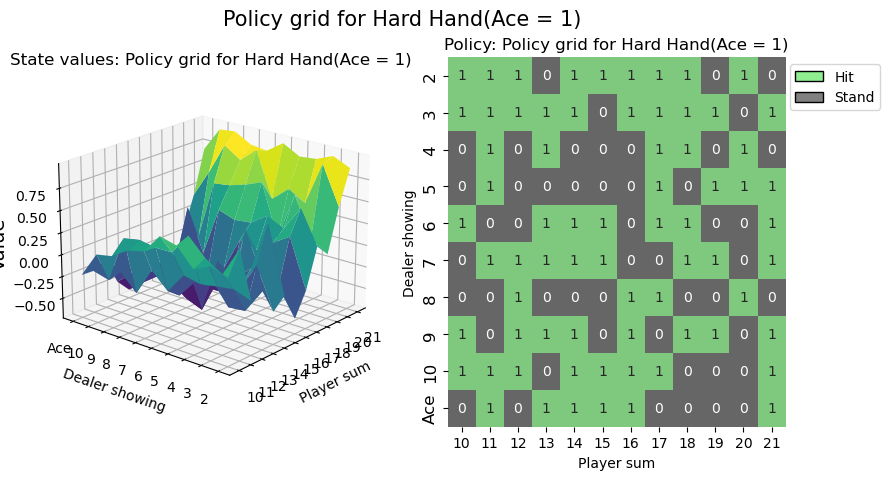

In [25]:
# state values (ace counts as 1)
value_grid, policy_grid = create_grids(agent, soft=False)
fig = plot_grids(value_grid, policy_grid, title="Policy grid for Hard Hand(Ace = 1)")
plt.show()